![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# **Taller No. 10 - ISIS4825**

## **Support Vector Machines, Modelo Conjuntos y Extracción de Características**
## **Contenido**
1. [**Objetivos**](#id1)
2. [**Problema**](#id2)
3. [**Importando las librerías necesarias para el laboratorio**](#id3)
4. [**Visualización y Análisis Exploratorio**](#id4)
5. [**Preparación de los Datos**](#id5)
6. [**Modelamiento**](#id6)
7. [**Predicción**](#id7)
8. [**Validación**](#id8)
9. [**Trabajo Asíncrono**](#id9)

## **Objetivos**<a name="id1"></a>
- Familiarizarse con las máquinas de soporte vectorial y los modelos conjuntos.
- Hacer un recorrido básico por las imágenes médicas.
- Extraer características básicas de imágenes.

## **Problema**<a name="id2"></a>
- En un dataset de imágenes médicas, buscamos clasificar todas aquellas imágenes que sean resonancias magnéticas de seno y tomografías de diafragma.

## **Notebook Configuration**

In [ ]:
!shred -u setup_colab.py
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_workshop_10()

## **Importando las librerías necesarias para el laboratorio**<a name="id3"></a>

In [62]:
from utils import general as gen

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             confusion_matrix, f1_score)
from sklearn.utils import resample

import numpy as np
import pandas as pd

from skimage import morphology, filters

import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
import seaborn as sns

from skimage import io

from tqdm.auto import tqdm

In [3]:
def cat_frequencies(labels):
    freq_p = labels.mean()
    freq_n = 1 - freq_p
    return freq_p, freq_n

### **Carga de Datos**

In [4]:
data_dir = "./data"

In [5]:
abdomen_dir = gen.create_and_verify(data_dir, "AbdomenCT")
breast_dir = gen.create_and_verify(data_dir, "BreastMRI")

abdomen_list = gen.read_listdir(abdomen_dir)
breast_list = gen.read_listdir(breast_dir)

abdomen_size = len(abdomen_list)
breast_size = len(breast_list)

In [6]:
total_data = np.zeros((breast_size + abdomen_size, 64, 64), dtype="uint8")
total_targets = np.zeros((breast_size + abdomen_size), dtype="uint8")

In [7]:
total_targets[:abdomen_size] = 1
total_targets[abdomen_size:] = 0

In [8]:
idx = 0
for dir_ in tqdm(gen.read_listdir(abdomen_dir)):
    total_data[idx] = io.imread(dir_)
    idx += 1

for dir_ in tqdm(gen.read_listdir(breast_dir)):
    total_data[idx] = io.imread(dir_)
    idx += 1

## **Visualización y Análisis Exploratorio**
- En este laboratorio usaremos otra variación menos conocida de MNIST que utiliza imágenes médicas, con resolución de 64x64, como resonancias, tomografías e imágenes por rayos-X. Para el desarrollo del taller, usaremos las imágenes pertenecientes a las categorías de `BreastMRI` y de `AbdomenCT`.

![image](https://docs.google.com/uc?export=download&id=1l1S12Jc_R6qvnQcAM_3WASK4wTMcJxvS)

> Tomado de: https://www.kenhub.com/en/library/anatomy/how-to-read-an-abdominal-ct y de https://www.cancernetwork.com/view/mri-improves-breast-cancer-screening-older-brca-carriers

In [26]:
total_data.shape

(18954, 64, 64)

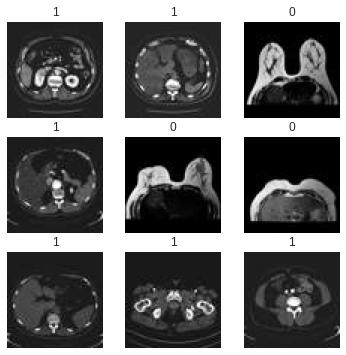

In [36]:
np.random.seed(5678)
random_sample = np.random.choice(range(total_data.shape[0]), size=9)
gen.visualize_subplot(
    total_data[random_sample],
    total_targets[random_sample], (3, 3), (6, 6)
)

## **Preparación de los Datos**

### **Redimensionamiento**

In [37]:
total_data.shape

(18954, 64, 64)

In [38]:
total_data = total_data.reshape(-1, 4096)

In [39]:
total_data.shape

(18954, 4096)

### **Train Set, Validation Set, Test Set**

In [40]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1234)

In [41]:
for train_index, test_index in sss.split(total_data, total_targets):
    full_X_train, X_test = total_data[train_index], total_data[test_index]
    full_y_train, y_test = total_targets[train_index], total_targets[test_index]

In [42]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=5678)

In [43]:
for train_index, val_index in sss.split(full_X_train, full_y_train):
    X_train, X_val = full_X_train[train_index], full_X_train[val_index]
    y_train, y_val = full_y_train[train_index], full_y_train[val_index]

In [46]:
fp, fn = cat_frequencies(total_targets)
fp, fn

(0.5275931201857128, 0.4724068798142872)

In [47]:
fp, fn = cat_frequencies(y_train)
fp, fn

(0.5276174773289365, 0.4723825226710635)

In [48]:
fp, fn = cat_frequencies(y_val)
fp, fn

(0.5275304978569073, 0.4724695021430927)

In [49]:
fp, fn = cat_frequencies(y_test)
fp, fn

(0.5275652862041678, 0.47243471379583224)

In [68]:
rnd_image = total_data[1]

In [69]:
rnd_image = rnd_image.reshape((64, 64))

In [84]:
rnd_image_top = morphology.white_tophat(rnd_image)

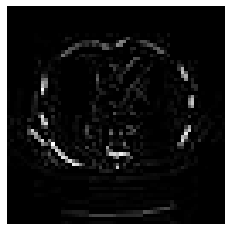

In [85]:
gen.imshow(rnd_image_top, color=False)

## **Modelamiento**
- En esta ocasión haremos uso de las máquinas de soporte vectorial (SVM).

In [50]:
svm_clf = SVC()

In [51]:
%%time
svm_clf.fit(X_train, y_train)

CPU times: user 10.5 s, sys: 343 ms, total: 10.8 s
Wall time: 10.9 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## **Predicción**

In [86]:
np.random.seed(1234)
random_sample = np.random.choice(range(X_test.shape[0]), size=9)
y_pred = svm_clf.predict(X_test[random_sample])

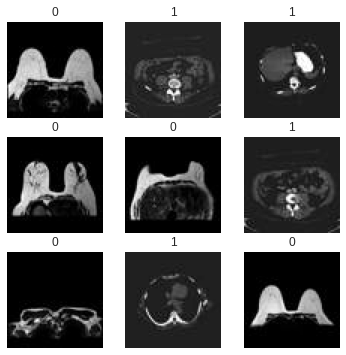

In [88]:
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 64, 64),
    y_pred, (3, 3), (6, 6)
)

## **Validación**

In [90]:
%%time
y_pred = svm_clf.predict(X_test)

CPU times: user 2.89 s, sys: 387 µs, total: 2.89 s
Wall time: 2.89 s


In [91]:
conf_matrix = confusion_matrix(y_test, y_pred)

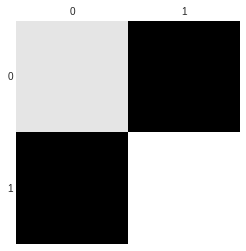

In [92]:
plt.matshow(conf_matrix, cmap="gray")
plt.show()

In [93]:
accuracy_score(y_test, y_pred)

1.0

In [94]:
recall_score(y_test, y_pred)

1.0

In [95]:
precision_score(y_test, y_pred)

1.0